# Stochastic Trajectory Prediction using LSTMs (cont'd)

### Quick demo of using the Agents LSTM model

This Notebook aims to show how we can utilise the implemented model in this repository.

### Initialisation

We begin by importing everything necessary including all datasets we will use for training, followed by assigning all constant variables we will need for training the network.



In [1]:
import os
import time

import numpy as np
import tensorflow as tf

from models.lstm import reset_graph
import utils.data_tools as data_tools
import utils.visualisation as visualisation
import utils.distributions as distributions

from models.agent_lstm import AgentLSTM
from models.agent_lstm import reset_graph


training_directories = ['../data/eth/univ',
                 '../data/ucy/zara/zara01',
                 '../data/ucy/zara/zara02']
dataset_names = ['univ', 'zara01', 'zara02']

DEFAULT_SEED = 12345
BATCH_SIZE = 10
NUM_EPOCHS = 100
DECAY_RATE = 0.95
SEQUENCE_LENGTH = 8
MAX_NUM_AGENTS = 40
SAVE_PATH = "../save"
RND = np.random.RandomState(DEFAULT_SEED)

/Users/alice/miniconda/envs/traj/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/alice/miniconda/envs/traj/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/alice/miniconda/envs/traj/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/alice/miniconda/envs/traj/lib/python3.6/site-

### Preparing the data and model
Before training, we need to preprocess and load our data. It is always good practice to reset the graph on Tensorflow in order to avoid interference with ran in parallel instances of the same graph.

In [2]:
loaded_data, frames_list, dataset_indices = data_tools.preprocess_frames(training_directories)
num_batches = data_tools.load_preprocessed_frames(loaded_data, BATCH_SIZE, SEQUENCE_LENGTH)

reset_graph()
lstm = AgentLSTM(
    batch_size=BATCH_SIZE,
    sequence_length=SEQUENCE_LENGTH,
    max_num_agents=MAX_NUM_AGENTS)

97
96
116
graph successfully reset
Frame number 0
Frame number 1
Frame number 2
Frame number 3
Frame number 4
Frame number 5
Frame number 6
Frame number 7


## Training

In order to train the network, we will begin by initialising a session, and then for as long as there are batches left, we will take a new one and run our model, at each such step the model updates its parameters. We repeat this process for a chosen in advance number of epochs.

Although not necessary, we can dedect the time it takes us to process a single batch. We will print the average result over 100 steps.

In [ ]:
for e in range(NUM_EPOCHS):
    # Reset the pointers
    pointer = data_tools.reset_batch_pointer()
    dataset_pointer = data_tools.reset_data_set_pointer()

    # Assign the learning rate (decayed acc. to the epoch number)
    lstm.sess.run(tf.assign(lstm.lr, lstm.learning_rate * (DECAY_RATE ** e)))
    # For each batch in this epoch
    for b in range(num_batches):
        start = time.time() # Tic
        # Get the source and target data of the current batch
        # x has the source data, y has the target data
        x, y, d, f, pointer, dataset_pointer = data_tools.next_batch_frame(
            loaded_data, frames_list, pointer, dataset_pointer, BATCH_SIZE, SEQUENCE_LENGTH, dataset_names, MAX_NUM_AGENTS, rnd=RND)

        x = np.array(x)
        y = np.array(y)
        train_loss = 0
        for batch in range(BATCH_SIZE):
            x_batch, y_batch = x[batch], y[batch]

            # Feed the source, target data and the initial LSTM state to the model
            feed = {
                lstm.input_data: x_batch,
                lstm.target_data: y_batch
            }
            # Fetch the loss of the model on this batch,
            # the final LSTM state from the session
            cur_train_loss, _ = lstm.sess.run(
                [lstm.cost, lstm.train_op], feed)
            train_loss += cur_train_loss

        end = time.time() # Toc
        train_loss = train_loss / BATCH_SIZE

        cur_time = end - start
        step = e * num_batches + b

        avg_time += cur_time
        avg_loss += train_loss

        # Print epoch, batch, loss and time taken
        if (step%99) == 0:
            print(
                "{}/{} (epoch {}), train_loss = {:.3f}, time/batch = {:.3f}"
                .format(
                    step,
                    NUM_EPOCHS * num_batches,
                    e,
                    avg_loss/99.0, avg_time/99.0))
            
            avg_time = 0
            avg_loss = 0

os.makedirs(SAVE_PATH, exist_ok=True)
# Save parameters after the network is trained
lstm.save_json(os.path.join(SAVE_PATH, "params_agent.json"))

## Test

In order to test we are no longer interested in obtaining entire batches but we need to consider single entries.
Moreover, we need to first observe part of the trajectory in order to make a prediction. Thus, we redefine some of the variables from above as follows.

We then take the test dataset, preprocess it and load it in a relevant format.

In [2]:
BATCH_SIZE = 1
OBSERVED_LENGTH = 4
PREDICTED_LENGTH = 4
SEQUENCE_LENGTH = OBSERVED_LENGTH + PREDICTED_LENGTH

test_directory = ["../data/eth/hotel"]
dataset_names = ['hotel']
loaded_data, frames_list, dataset_indices = data_tools.preprocess_frames(test_directory)
num_batches = data_tools.load_preprocessed_frames(loaded_data, BATCH_SIZE, SEQUENCE_LENGTH)

129


We define a model with a sequence length of 1 since we will be predicting for each step individually.

In [19]:
reset_graph()

lstm = AgentLSTM(batch_size=1, sequence_length=1, mode='infer')
lstm.load_json(os.path.join(SAVE_PATH, "params_agent.json"))

pointer = data_tools.reset_batch_pointer()
dataset_pointer = data_tools.reset_data_set_pointer()

xs = []
ys = []
total_error = 0
initial_states = lstm.sess.run(lstm.LSTM_states)

desired_frame_to_plot = 1.0

graph successfully reset
Frame number 0


### Inference

For a given trajectory, the idea is to simply update the cell state at each step using the final cell state value from our previous prediction.

We then measure the performance of the network through the average displacement error.

In [20]:
for b in range(num_batches):
    x, y, d, f, pointer, dataset_pointer = data_tools.next_batch_frame(
            loaded_data, frames_list, pointer, dataset_pointer, BATCH_SIZE, SEQUENCE_LENGTH, dataset_names, MAX_NUM_AGENTS, random_update=False, rnd=RND)
    
    x = np.array(x)
    y = np.array(y)
    obs_traj = x[0,:OBSERVED_LENGTH]
    states = initial_states
    for idx, position in enumerate(obs_traj[:-1]):
        # Create the input data tensor
        input_data_tensor = np.reshape(position, (1, MAX_NUM_AGENTS, 3))
        target_data_tensor = np.reshape(obs_traj[idx+1], (1, MAX_NUM_AGENTS, 3))
        # Create the feed dict
        feed = {lstm.input_data: input_data_tensor, lstm.target_data: target_data_tensor, lstm.LSTM_states: states}
        # Get the final state after processing the current position
        [states, cost] = lstm.sess.run([lstm.final_states, lstm.cost], feed)

    returned_traj = obs_traj
    last_position = obs_traj[-1]

    prev_data = np.reshape(last_position, (1, MAX_NUM_AGENTS, 3))
    prev_target_data = np.reshape(x[0][obs_traj.shape[0]], (1, MAX_NUM_AGENTS, 3))
    for t in range(PREDICTED_LENGTH):
        feed = {
            lstm.input_data: prev_data,
            lstm.LSTM_states: states,
            lstm.target_data: prev_target_data}

        [output, states] = lstm.sess.run(
            [lstm.final_output, lstm.final_states], feed)
        newpos = np.zeros((1, MAX_NUM_AGENTS, 3))
        for a_index, a_output in enumerate(output):
            [o_mux, o_muy, o_sx, o_sy, o_corr] = np.split(a_output[0], 5, 0)
            mux, muy, sx, sy, corr = [o_mux], [o_muy], [np.exp(o_sx)], [np.exp(o_sy)], [np.tanh(o_corr)]
            next_x, next_y = distributions.sample_2d_normal(mux, muy, sx, sy, corr)
            newpos[0, a_index, :] = [prev_data[0, a_index, 0], next_x, next_y]

        returned_traj = np.vstack((returned_traj, newpos))
        prev_data = newpos
        if t != PREDICTED_LENGTH - 1:
            prev_target_data = np.reshape(x[0][obs_traj.shape[0] + t + 1], (1, MAX_NUM_AGENTS, 3))

    complete_traj = returned_traj
    first = True
    if f[0][0] == desired_frame_to_plot:
        for agent in range(40):
        # if x[0, OBSERVED_LENGTH, agent, 0] != 0.0:
            if len(np.unique(x[:, :, agent, 1])) > OBSERVED_LENGTH+1 or len(np.unique(x[:, :, agent, 2])) > OBSERVED_LENGTH+1:
                if first:
                        agents_to_use = []
                        traj_to_plot = []
                        targ_to_plot = []
                        frames_to_use = []
                        first = False
                agents_to_use.append(agent)
                added = False
                traj_to_plot = complete_traj.copy()
                targ_to_plot = x.copy()
                frames_to_use = f.copy()

    total_error += distributions.get_mean_error_perframe(complete_traj, x[0], OBSERVED_LENGTH, MAX_NUM_AGENTS)
    if (b+1) % 10 == 0:
        print("Processed trajectory number : ", b+1, "out of ", num_batches, " trajectories")

print("Processed trajectory number : ", b+1, "out of ", num_batches, " trajectories")
print("Total mean error of the model is ", total_error/num_batches)

tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
tuk samo vednaj
Processed trajectory number :  10 out of  258  trajectories
Processed trajectory number :  20 out of  258  trajectories
Processed trajectory number :  30 out of  258  trajectories
Processed trajectory number :  40 out of  258  trajectories
Processed trajectory number :  50 out of  258  trajectories
Processed trajectory number :  60 out of  258  trajectories


In [21]:
frames_to_use

[array([ 1., 11., 21., 31., 41., 51., 61., 71.])]

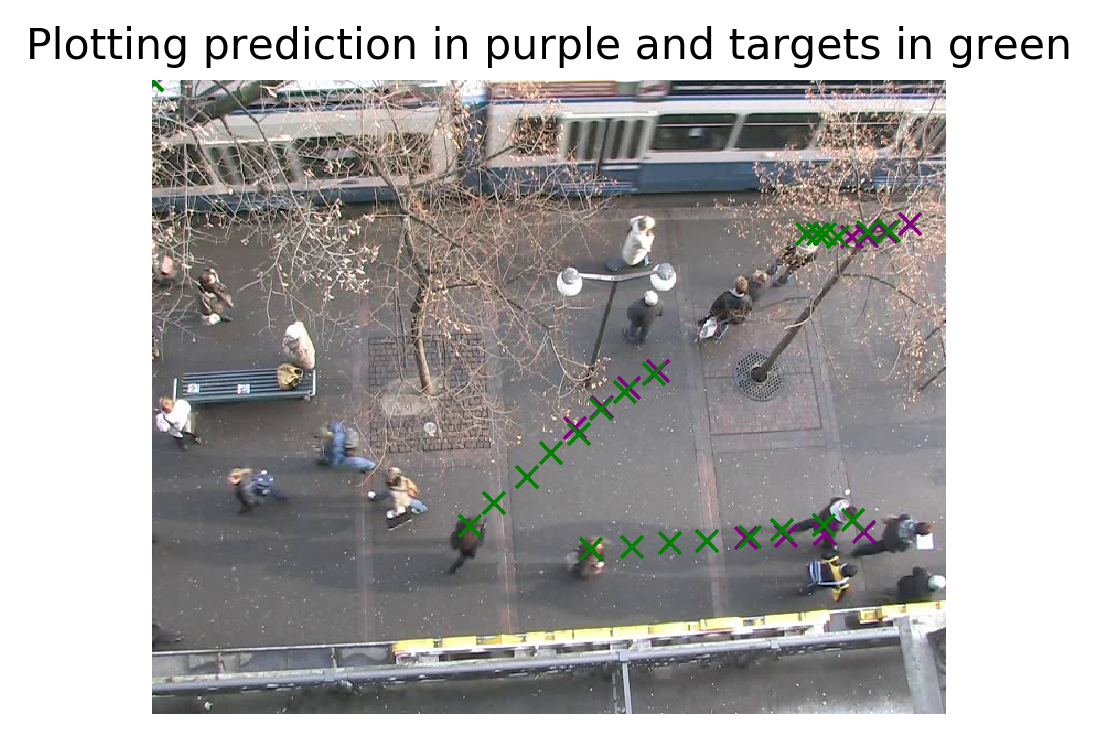

In [22]:
import matplotlib.pyplot as plt
import cv2
# from scipy.misc import imresize as resize
POS_MSEC = cv2.CAP_PROP_POS_MSEC
POS_FRAMES = cv2.CAP_PROP_POS_FRAMES
videopath_dir = {
    'hotel': '../data/seq_hotel/seq_hotel.avi'}

name = 'hotel'
height = 576
width = 720
frame_id = frames_to_use[0][0]
blocking = False

videopath = videopath_dir[name]
captured = cv2.VideoCapture(videopath)
captured.set(POS_FRAMES, int(frame_id))
frame_num = int(captured.get(POS_FRAMES))
now = int(captured.get(POS_MSEC) / 1000)
_, frame = captured.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(4, 4), dpi=256)
for idx, agent in enumerate(agents_to_use):
    for i in range(len(x[0])):
        if x[0, i, agent, 1] > 0.0 or x[0, i, agent, 2] > 0.0:
            start = i
            break
    # without the up_to_idx
    plt.plot(traj_to_plot[OBSERVED_LENGTH:, agent, 2]*width, traj_to_plot[OBSERVED_LENGTH:, agent, 1]*height, 'x', c='#800080')
    plt.plot(targ_to_plot[:, :, agent, 2]*width, targ_to_plot[:, :, agent, 1]*height, 'x', c='green')


plt.imshow(frame)
plt.axis('off')
plt.title("Plotting prediction in purple and targets in green")
plt.show()